### ライブラリの準備

###モジュールのインポート

In [1]:
import os
import math
import numpy as np
import pickle
import matplotlib.pyplot as plt
import datetime
#from tqdm import tqdm
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from collections import deque
from typing import Sequence, Dict, Tuple, Union

import torch
from torch import nn
from torch.amp import autocast, GradScaler
import torch.nn.functional as F
import torchvision.datasets as dataset
from torchvision.transforms import v2
import torchvision.transforms as T
from torch.nn.init import constant_, xavier_uniform_, kaiming_uniform_, xavier_normal_, kaiming_normal_

from transformers import  CLIPVisionModel, get_linear_schedule_with_warmup, BertTokenizer, BertForMaskedLM

import util
import levenshtein
from nltk import bleu_score
#from cidereval import cider, ciderD

In [2]:
class PositionalEmbedding(nn.Module):
    '''
    位置埋め込み （Positional embedding）
    dim_embedding: 埋込み次元
    max_len      : 入力の最大系列長
    '''
    def __init__(self, dim_embedding: int, max_len: int=2048):
        super().__init__()

        self.pos_emb = nn.Embedding(max_len, dim_embedding)

    '''
    位置エンコーディングの順伝播
    x: 位置エンコーディングを埋め込む対象のテンソル,
       [バッチサイズ, 系列長, 埋め込み次元]
    '''
    def forward(self, x: torch.Tensor):
        seq = x.shape[1]
        #positions = torch.arange(start=0, end=seq, step=1, device=x.device, requires_grad = False ).to(torch.long)
        positions = torch.arange(start=0, end=seq, step=1, device=x.device ).to(torch.long)
        positions = self.pos_emb(positions)[:seq,:]
        
        return positions

### CaptioningTransformer

In [3]:
class CaptioningTransformer(nn.Module):
    '''
    CaptioningTransformerのコンストラクタ
    dim_embedding  : 埋め込み次元
    dim_feedforward: FNNの中間特徴次元
    num_heads      : マルチヘッドアテンションのヘッド数
    num_layers     : Transformerデコーダ層の数
    vocab_size     : 辞書の次元
    null_index     : NULLのID
    dropout        : ドロップアウト確率
    '''
    def __init__(self, img_size: int, length_max: int, dim_embedding: int, num_heads: int, 
                 prop_dec_num_layers: int, aux_dec_num_layers: int, vocab_size: int, tokenizer,
                 dropout: float = 0.1, pad_token_id: int=0):
        super().__init__()

        #CLIP
        model_id = "openai/clip-vit-large-patch14-336"
        self.clip_model = CLIPVisionModel.from_pretrained(model_id, output_hidden_states = True)
        images = torch.randn( ( 1, 3, img_size, img_size ) )
        memory = self.clip_model( images )
        memory = memory.last_hidden_state
        img_length = memory.size(1)
        clip_dim = memory.size(2)
        
        # Dense Connector

        self.dc_linear = nn.Linear( clip_dim * 3, dim_embedding )
        self.dropout = nn.Dropout( dropout )        
        self.ln_memory = nn.LayerNorm( dim_embedding )

        # Down Sampling
        stride = img_length // ( length_max - 1 )
        self.conv1 = nn.Conv1d( dim_embedding, dim_embedding, 1, stride )
        print( "img_length:", img_length )
        print( "text_length_max:", length_max )
        print( "stride:", stride )
        tgt = self.conv1( memory.transpose(1,2) ).transpose(1,2)
        print( "tgt size:", tgt.size() )

        
        # proper decoder
        self.prop_decoder_layers = nn.ModuleList([
            nn.TransformerDecoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True, norm_first = True, activation='gelu')
            for _ in range(prop_dec_num_layers)
        ])

        self.prop_ln = nn.LayerNorm( dim_embedding )
        # 単語出力分布計算
        self.prop_linear = nn.Linear(dim_embedding, vocab_size)        

        # Word Embeidding
        #self.emb = nn.Embedding( vocab_size, dim_embedding, padding_idx = tokenizer.pad_token_id )
        # Word Embeidding
        self.emb = nn.Embedding( vocab_size, dim_embedding )
        
        ## 位置エンコーディング
        self.pos_emb = PositionalEmbedding(dim_embedding)
        
        #dropout
        self.dropout = nn.Dropout( dropout )
        
        # aux decoder
        self.aux_decoder_layers = nn.ModuleList([
            nn.TransformerDecoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True, norm_first = True, activation='gelu')
            for _ in range(aux_dec_num_layers)
        ])

        self.aux_ln = nn.LayerNorm( dim_embedding )
        # 単語出力分布計算
        self.aux_linear = nn.Linear(dim_embedding, vocab_size)        
        
        # Others
        self.dim_embedding = dim_embedding
        self.tokenizer = tokenizer
        self.pad_token_id = pad_token_id
        self._reset_parameters(self)

    def _reset_parameters(self, model ):
        for name, module in model.named_modules():
            #print("name:",name)
            if "clip_model" not in name and "prop_decoder" in name:
                if isinstance( module, nn.Linear ):
                    #print("name1:", name )
                    for name, p in module.named_parameters():
                        xavier_uniform_(module.weight)
                        nn.init.zeros_(module.bias)
                        #if name == "weight":
                            #print( "name2:", name)
                            #xavier_uniform_(p)
                            #xavier_normal_(p)
                            #kaiming_uniform_(p)
                            #kaiming_normal_(p)
                            #nn.init.normal_(p, mean=0.0, std=0.02)
                        #elif name == "bias":
                        #    nn.init.zeros_(p)
                elif isinstance( module, nn.Embedding):
                    nn.init.normal_(module.weight, mean=0.0, std=0.02)
                elif isinstance(module, nn.LayerNorm):
                    nn.init.zeros_(module.bias)
                    nn.init.ones_(module.weight)  
            elif "clip_model" not in name and "aux_decoder" in name:
                if isinstance( module, nn.Linear ):
                    #print("name1:", name )
                    for name, p in module.named_parameters():
                        xavier_uniform_(module.weight)
                        nn.init.zeros_(module.bias)
                        #if name == "weight":
                            #print( "name2:", name)
                            #xavier_uniform_(p)
                            #xavier_normal_(p)
                            #kaiming_uniform_(p)
                            #kaiming_normal_(p)
                            #nn.init.normal_(p, mean=0.0, std=0.02)
                        #elif name == "bias":
                        #    nn.init.zeros_(p)
                elif isinstance( module, nn.Embedding):
                    nn.init.normal_(module.weight, mean=0.0, std=0.02)
                elif isinstance(module, nn.LayerNorm):
                    nn.init.zeros_(module.bias)
                    nn.init.ones_(module.weight)  
    
            #if isinstance(module, nn.Linear):
            #    nn.init.normal_(module.weight, mean=0.0, std=0.02)
            #    if module.bias is not None:
            #        nn.init.zeros_(module.bias)
            #elif isinstance(module, nn.Embedding):
            #    nn.init.normal_(module.weight, mean=0.0, std=0.02)
            #elif isinstance(module, nn.LayerNorm):
            #    nn.init.zeros_(module.bias)
            #    nn.init.ones_(module.weight)  

    ''' CaptioningTransformerの順伝播処理
    features: 画像特徴量 [バッチサイズ, 埋め込み次元]
    captions: 正解キャプション [バッチサイズ, 系列長]
    '''
    def forward(self, images: torch.Tensor, captions: torch.Tensor ):

        self.device = images.device

        memory = self.clip_model( images )
        memory = self.dense_connector( memory )
        memory = self.dropout( memory )
        memory = self.ln_memory( memory )
        aux_memory = memory # cross entropy 計算のため

        tgt = self.conv1( memory.transpose(1,2) ).transpose(1,2)
        
        # ctc loss 計算のため
        for layer in self.prop_decoder_layers:
            tgt = layer( tgt, memory, tgt_mask = None, tgt_key_padding_mask = None, 
                       memory_key_padding_mask = None, tgt_is_causal = False )        
            
        # 単語出力分布計算
        tgt = self.prop_ln( tgt )
        prop_logits = self.prop_linear( tgt )

        # cross entropy 計算のため    
        aux_tgt = self.emb( captions ) * math.sqrt(self.dim_embedding)
        
        position = self.pos_emb( aux_tgt )
        aux_tgt += position

        #dropout
        aux_tgt = self.dropout( aux_tgt )        
            
        #aux_tgt_key_padding_mask = torch.eq( captions, self.pad_token_id )
        aux_tgt_key_padding_mask = None
        #aux_tgt_mask = nn.Transformer.generate_square_subsequent_mask( captions.size(1), dtype=bool, device=self.device )
        aux_tgt_mask = None
        
        for layer in self.aux_decoder_layers:
            aux_tgt = layer( aux_tgt, aux_memory, tgt_mask = aux_tgt_mask, tgt_key_padding_mask = aux_tgt_key_padding_mask, 
                       memory_key_padding_mask = None, tgt_is_causal = False )        
                       #memory_key_padding_mask = None, tgt_is_causal = True )        
        # 単語出力分布計算
        aux_tgt = self.aux_ln( aux_tgt )
        aux_logits = self.aux_linear( aux_tgt )
            
        return prop_logits, aux_logits

    def dense_connector(self, memory ):
        tmp1 = torch.tensor([], device = self.device  )
        tmp2 = torch.tensor([], device = self.device  )
        tmp_full = len( memory.hidden_states )
        tmp_half = tmp_full // 2
        for i in range( 0, tmp_half ):
            tmp1 = torch.cat( [tmp1, memory.hidden_states[i][None]], dim = 0 )
        tmp1 = torch.sum(tmp1, dim=0) / tmp_half
        for i in range( tmp_half, tmp_full ):
            tmp2 = torch.cat( [tmp2, memory.hidden_states[i][None]], dim = 0 )
        tmp2 = torch.sum(tmp2, dim=0 ) / ( tmp_full - tmp_half )
        tmp3 = torch.cat([tmp1, tmp2], dim=-1)
        tmp3 = torch.cat( [ memory.last_hidden_state, tmp3], dim = -1 )
        #tmp3 = sel.dc_ln( tmp3 )
        tmp3 = self.dc_linear( tmp3 )
        return tmp3
    '''
    def dense_connector(self, memory ):
        tmp = torch.zeros_like( memory.hidden_states[0] )
        for tmp1 in memory.hidden_states:
            tmp += tmp1
        tmp += memory.last_hidden_state
        tmp /= (len( memory.hidden_states) + 1 )

        tmp = self.dc_linear( tmp )

        return tmp
    '''

In [4]:
class MyDataset(Dataset):
    def __init__(self, file_path: str, img_directory: str, transforms, tokenizer, length_max = None ) -> None:
        super().__init__()
        self.img_directory = img_directory
        self.transforms = transforms
        # TODO: fix to original data
        #画像の前処理
        self.img_file = []
        self.tokens = []
        #vocab_size = len( tokenizer )
        #c1 = torch.zeros( ( vocab_size ) )
        #c2 = torch.zeros( ( vocab_size, vocab_size ) )
        if length_max == None:
            self.length_max = 0
        else:
            self.length_max = length_max
        length_sum = 0

        with open( file_path, 'rb') as f:
            data = pickle.load(f)
        for i, line_data in enumerate( data ):
            if i % 100000 == 0:
                print( "i:", i )
            self.img_file.append( line_data['img_file'] )
            id_tokens = line_data['id_tokens']
            length_sum += len( id_tokens )
            if length_max != None:
                id_tokens = torch.tensor( id_tokens )[:self.length_max]
            else:
                if self.length_max < len( id_tokens ):
                    self.length_max = len( id_tokens )
                id_tokens = torch.tensor( id_tokens )
            self.tokens.append( id_tokens )
        # w1, w2 を作る時は length_max = None　でお願いします。
        #    for i2 in range( len(id_tokens) ):
        #        if i2 == len( id_tokens ) - 1:
        #            c1[id_tokens[i2]] += 1
        #        else:
        #            c1[id_tokens[i2]] += 1
        #            c2[id_tokens[i2], id_tokens[i2+1] ] += 1
        '''
        c1avg = int( torch.sum( c1 ) / torch.sum( torch.ne( c1, 0 ).int()) )
        c2avg = int( torch.sum( torch.sum( c2, dim = 1 ), dim = 0 ) / torch.sum( torch.ne( c2, 0 ).int() ) )

        c1[0] = c1avg

        c2[:,0] = c2avg
        c2[0,:] = c2avg
        
        sumc1 = torch.sum( c1, dim = 0 )
        sumc2 = torch.sum( torch.sum( c2, dim = 1 ), dim = 0 )

        prob1 = c1 / sumc1
        prob2 = c2 / sumc2

        self.w1 = prob1 ** -0.4
        self.w1 = torch.nan_to_num( self.w1, nan = 0.0, posinf=0.0, neginf=0.0 )
        avg1 = torch.sum( self.w1, dim = 0 ) / torch.sum( torch.ne( self.w1, 0.0 ).int() )
        self.w1 = self.w1 / avg1

        self.w2 = prob2 ** -0.4
        self.w2 = torch.nan_to_num( self.w2, nan = 0.0, posinf=0.0, neginf=0.0 )
        avg2 = torch.sum( torch.sum( self.w2, dim = 1 ), dim = 0 ) / torch.sum( torch.ne( self.w2, 0.0 ).int() )
        self.w2 = self.w2 / avg2

        with open( "/mnt/ssd2/v7/w_unigrma.pkl", mode="wb" ) as f:
            pickle.dump( self.w1, f )

        with open( "/mnt/ssd2/v7/w_bigrma.pkl", mode="wb" ) as f:
            pickle.dump( self.w2, f )
        
        '''

        #with open( "/mnt/ssd2/v7/w_unigram.pkl", 'rb') as f:
        #    self.w1 = pickle.load(f)

        #with open( "/mnt/ssd2/v7/w_bigram.pkl", 'rb') as f:
        #    self.w2 = pickle.load(f)
        
        if length_max == None:
            print( "length max:", self.length_max )
            print( "avg length:", length_sum / len( self.tokens ) )
    
    # ここで取り出すデータを指定している
    def __getitem__(
        self,
        index: int
    ):
        tokens = self.tokens[index]
        img_file = self.img_file[index] + ".jpg"
        img_path = os.path.join( self.img_directory, img_file ) #index番目の画像のパスを取得
        img = Image.open(img_path) #PIL形式で画像を読み込み
        if img.mode != 'RGB':
            img = img.convert("RGB")
        img = self.transforms(img)
        
        return img, tokens

    # この method がないと DataLoader を呼び出す際にエラーを吐かれる
    def __len__(self) -> int:
        return len(self.tokens)

    def length_max(self):
        return self.length_max

    #def w1(self):
    #    return self.w1

    #def w2(self):
    #    return self.w2

In [5]:
def collate_func(batch: Sequence[Tuple[Union[torch.Tensor, str]]], pad_index, length_max ):
    imgs, tokens = zip(*batch)

    max_length = length_max
    #max_length = 0
    #for target in tokens:
    #    if max_length < len( target ):
    #        max_length = len( target )
    
    targets = []
    lengths = []
    for target in tokens:
        pad_len = max_length - len( target ) 
        #print( "target:", target )
        input2= F.pad( target, (0, pad_len), mode='constant', value = pad_index)
        targets.append( input2 )
        lengths.append( len( target ) )
    
    imgs = torch.stack( imgs, dim = 0 )
    targets = torch.stack( targets, dim = 0 )
    lengths = torch.tensor( lengths, requires_grad = False  )

    #if imgs.dim() != 4:
    #   print( "in collate imgs size:", imgs.size() )
    
    return imgs, targets, lengths

In [6]:
#path = "../CLIP_ENCODER/models--google-bert--bert-large-uncased/snapshots/6da4b6a26a1877e173fca3225479512db81a5e5b"
#tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path = path)
model_id = "google-bert/bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained(model_id)
blank_token_id = tokenizer.encode( [ "[unused0]"] )[1]
print( "blank token_id:", blank_token_id )


caption = "Hello World!".lower()
token_ids = tokenizer.encode( caption )
print( token_ids )
#decoded = tokenizer.tokenize( token_ids )
#print( decoded )
decoded = tokenizer.decode( token_ids )
print( decoded )
#print( tokenizer.tokenize( decoded ) )
#individual_decoded_tokens = list(map(tokenizer.decode, token_ids))
individual_decoded_tokens = [tokenizer.decode( [token], skip_special_tokens = True ) for token in token_ids ]
individual_decoded_tokens2 = [tokens for tokens in individual_decoded_tokens if tokens != '' ]
print( individual_decoded_tokens2 )

/home/uchiyats/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


blank token_id: 1
[101, 7592, 2088, 999, 102]


2025-10-03 06:30:59.849010: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-03 06:30:59.861083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759440659.877780   14821 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759440659.883156   14821 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759440659.895305   14821 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[CLS] hello world! [SEP]
['hello', 'world', '!']


blank  token_id: 1


Some weights of the model checkpoint at google-bert/bert-large-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


i: 0
i: 100000
i: 200000
i: 300000
i: 400000
i: 500000
avg len: 42.0877771734418
train_dataset.length_max: 294
torch.Size([4, 56])
torch.Size([4, 3, 336, 336])


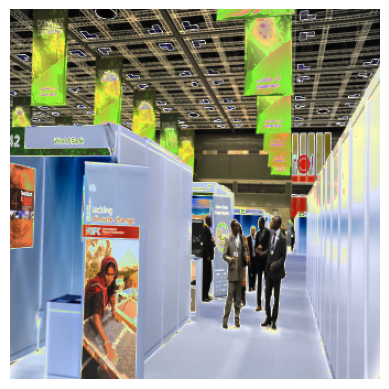

In [8]:
device = torch.device( 'cpu' )
#path = "../CLIP_ENCODER/models--google-bert--bert-large-uncased/snapshots/6da4b6a26a1877e173fca3225479512db81a5e5b"
#tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path = path)
model_id = "google-bert/bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained(model_id)
blank_token_id = tokenizer.encode( [ "[unused0]"] )[1]
print( "blank  token_id:", blank_token_id )
collate_func_lambda = lambda x: collate_func(x, tokenizer.pad_token_id)

#path = "../CLIP_ENCODER/models--google-bert--bert-large-uncased/snapshots/6da4b6a26a1877e173fca3225479512db81a5e5b"
#kd_model = BertForMaskedLM.from_pretrained(pretrained_model_name_or_path = path).to(config.device)
model_id = "google-bert/bert-large-uncased"
kd_model = BertForMaskedLM.from_pretrained(model_id).to(device)

# 画像のtransformsを定義
transforms = v2.Compose([
    v2.Resize((336, 336)),
    #v2.ToTensor(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.AutoAugment(),
    ## Coco データセット 2017 train の平均と標準偏差
    #v2.Normalize((0.456,0.427,0.401),(0.224,0.219,0.231) )
    # Clip Model の config から引用。
    v2.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

# 画像のtransformsを定義
#transforms = T.Compose([
#    T.Resize((336, 336)),
#    T.RandomHorizontalFlip(),
#    T.ToTensor(),
#    # ImageNetデータセットの平均と標準偏差
#    T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
#])


# v7 データセット
train_dataset = MyDataset( file_path="/mnt/ssd2/v7/data.pkl",
                           img_directory = "/mnt/ssd2/v7/img",
                           #img_directory = "smb://192.168.1.2/img/v7/",
                           transforms=transforms, tokenizer = tokenizer, length_max = 97 )

print( "train_dataset.length_max:", train_dataset.length_max )

# Subset samplerの生成
#val_set, train_set = util.generate_subset(
#    train_dataset, config.val_ratio)
test_set, val_set, train_set = util.generate_subset_test_val_train(
    train_dataset, 0.1, 0.1 )
    
# 学習時にランダムにサンプルするためのサンプラー
train_sampler = SubsetRandomSampler(train_set)

# DataLoaderを生成
collate_func_lambda = lambda x: collate_func(x, tokenizer.pad_token_id, length_max = 97 )
train_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=4,
                    num_workers=0,
                    shuffle = False,
                    #sampler=train_sampler,
                    pin_memory = True,
                    collate_fn=collate_func_lambda)
transforms_inv = v2.Compose([
    v2.Normalize((-0.48145466/0.26862954, -0.4578275/0.26130258, -0.40821073/0.27577711), (1/0.26862954,1/0.26130258,1/0.27577711)),
    v2.ToPILImage()
])


#for n, (imgs, targets, lengths) in enumerate( train_loader ):
#    #print( "imgs size:", imgs.size())
#    if n % 100 == 0:
#        print( "n:", n )
    
imgs, targets, lengths = next(iter(train_loader))

##print( targets )
print( targets.size() )
print( imgs.size() )
##print( imgs[0] )
##img[0].show()
inv_img = transforms_inv( imgs[0] )
plt.imshow( inv_img )
plt.axis('off')
plt.show()

###学習におけるハイパーパラメータやオプションの設定

In [6]:
class ConfigTrain(object):
    '''
    ハイパーパラメータ、システム共通変数の設定
    '''
    def __init__(self):

        # ハイパーパラメータ
        #self.clip_dim = 1024
        self.img_size = 336
        self.dim_embedding = 1024   # 埋め込み層の次元
        self.num_heads = 16
        #self.num_heads = 20
        #self.prop_dec_num_layers = 12
        self.prop_dec_num_layers = 24
        #self.aux_dec_num_layers = 12
        self.aux_dec_num_layers = 24
        self.length_max = 97
        #self.lr = 5e-5            # 学習率
        #self.lr = 2e-5            # 学習率
        #self.lr = 1e-5            # 学習率
        #self.lr = 2e-6            # 学習率
        #self.lr = 1e-6            # 学習率
        #self.lr = 5e-7            # 学習率
        #self.lr_clip = 2e-7            # 学習率
        self.lr_clip = 2e-7            # 学習率
        self.lr_prop_decoder = 1e-4            # 学習率
        self.lr_aux_decoder = 1e-4            # 学習率
        self.lr_others = 1e-4
        self.dropout = 0.1
        #self.batch_size = 128       # ミニバッチ数
        #self.batch_size = 24       # ミニバッチ数
        #self.batch_size = 16       # ミニバッチ数
        self.batch_size = 12       # ミニバッチ数
        #self.batch_size = 8       # ミニバッチ数
        #self.batch_size = 6       # ミニバッチ数
        #self.batch_size = 4       # ミニバッチ数
        #self.batch_size = 2       # ミニバッチ数
        #self.batch_size = 1       # ミニバッチ数
        #self.num_epochs = 100       # エポック数→Colab無料版でテストする際は10未満に修正を推奨
        #self.num_epochs = 60       # エポック数→Colab無料版でテストする際は10未満に修正を推奨
        self.num_epochs = 10       # エポック数→Colab無料版でテストする際は10未満に修正を推奨
        #self.num_epochs = 5       # エポック数→Colab無料版でテストする際は10未満に修正を推奨
        self.use_amp = True
        #self.use_amp = False
        #self.use_saved_pth = True
        self.use_saved_pth = False
        self.vocab_size = len( tokenizer )
        self.alpha = 0.3
        self.T = 1.0
        self.weight_decay = 0.1
        self.betas = (0.9, 0.999 )
        self.warmup = 0.1

        # パスの設定
        self.img_directory = '/mnt/ssd2/v7/img'
        self.anno_file = '/mnt/ssd2/v7/data.pkl'
        self.save_directory = './model'

        # 検証に使う学習セット内のデータの割合
        self.test_ratio = 0.1
        self.val_ratio = 0.1
        #self.val_ratio = 0.0004
        #self.test_ratio = 0.0004
        
        # 学習に使うデバイス
        #self.device = 'cuda'
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        #self.device = 'cpu'
        
        # データローダーに使うCPUプロセスの数
        #self.num_workers = 4
        self.num_workers = 0 if self.device == torch.device('cpu') else 8
        #self.num_workers = 0 if self.device == torch.device('cpu') else 6
        #self.num_workers = 0
        
        # 移動平均で計算する損失の値の数
        self.moving_avg = 100

In [10]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
#path = "../CLIP_ENCODER/models--google-bert--bert-large-uncased/snapshots/6da4b6a26a1877e173fca3225479512db81a5e5b"
#tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path = path)
model_id = "google-bert/bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained(model_id)
blank_token_id = tokenizer.encode( [ "[unused0]"] )[1]
print( "blank token_id:", blank_token_id )
model = CaptioningTransformer( img_size = 336, length_max = train_dataset.length_max, dim_embedding=1280, num_heads = 16, \
                               prop_dec_num_layers = 12, aux_dec_num_layers=12, vocab_size=len(tokenizer),tokenizer=tokenizer, \
                               dropout = 0.1, pad_token_id = tokenizer.pad_token_id ).to(device)
images = torch.randn( ( 2, 3, 336,336 ), device = device )
captions = torch.randint( 0, len(tokenizer), size=( 2, 50  ), device = device )
prop_logits, aux_logits = model( images, captions[:,:-1] )

print( prop_logits.size() )
print( aux_logits.size() )

blank token_id: 1
img_length: 577
text_length_max: 294
stride: 1
torch.Size([2, 577, 30522])
torch.Size([2, 49, 30522])


In [7]:
def ctc_simple_decode(int_vector, tokenizer):
    ''' 以下の手順で，フレーム単位のCTC出力をトークン列に変換する
        1. 同じ文字が連続して出現する場合は削除
        2. blank を削除
    int_vector: フレーム単位のCTC出力(整数値列)
    token_list: トークンリスト
    output:     トークン列
    '''
    # 出力文字列
    output = []
    # 一つ前フレームの文字番号
    prev_token = -1
    # フレーム毎の出力文字系列を前から順番にチェックしていく
    for n in int_vector:
        n = n.item()
        if n != prev_token:
            # 1. 前フレームと同じトークンではない
            if n != tokenizer.encode( [ "[unused0]"] )[1] and n != tokenizer.encode( [ "[CLS]"] )[1] \
                and n != tokenizer.encode( [ "[SEP]"] )[1] and n != tokenizer.encode( [ "[PAD]"] )[1]:
                # 2. かつ，blank(番号=0)ではない
                # --> token_listから対応する文字を抽出し，
                #     出力文字列に加える
                output.append( tokenizer.decode( [n] ) )
            # 前フレームのトークンを更新
            prev_token = n
        if n == tokenizer.encode( ["[SEP]"] )[1]:
            break
    return output

### 学習を行う

In [8]:
#path = "../CLIP_ENCODER/models--google-bert--bert-large-uncased/snapshots/6da4b6a26a1877e173fca3225479512db81a5e5b"
#tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path = path)
model_id = "google-bert/bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained(model_id)
blank_token_id = tokenizer.encode( [ "[unused0]"] )[1]
print( "blank token_id:", blank_token_id )

config = ConfigTrain()

print( "use_amp:", config.use_amp )

#path = "../CLIP_ENCODER/models--google-bert--bert-large-uncased/snapshots/6da4b6a26a1877e173fca3225479512db81a5e5b"
#kd_model = BertForMaskedLM.from_pretrained(pretrained_model_name_or_path = path).to(config.device)
model_id = "google-bert/bert-large-uncased"
kd_model = BertForMaskedLM.from_pretrained(model_id).to(config.device)

# モデル出力用のディレクトリを作成
os.makedirs(config.save_directory, exist_ok=True)

# 画像のtransformsを定義
transforms = v2.Compose([
    v2.Resize((config.img_size, config.img_size)),
    #v2.ToTensor(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.AutoAugment(),
    ## Coco データセット 2017 train の平均と標準偏差
    #v2.Normalize((0.456,0.427,0.401),(0.224,0.219,0.231) )
    # Clip Model の config から引用。
    v2.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

# v7 データセット
train_dataset = MyDataset( file_path=config.anno_file,
                           img_directory = config.img_directory,
                           transforms=transforms,tokenizer=tokenizer, length_max = config.length_max)

# Subset samplerの生成
test_set, val_set, train_set = util.generate_subset_test_val_train(
    train_dataset, config.test_ratio, config.val_ratio )
    
# 学習時にランダムにサンプルするためのサンプラー
train_sampler = SubsetRandomSampler(train_set)

# DataLoaderを生成
collate_func_lambda = lambda x: collate_func(x, tokenizer.pad_token_id, config.length_max)
train_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=config.batch_size,
                    num_workers=config.num_workers,
                    sampler=train_sampler,
                    collate_fn=collate_func_lambda)

val_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=config.batch_size,
                    num_workers=config.num_workers,
                    sampler=val_set,
                    collate_fn=collate_func_lambda)

test_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    #batch_size=config.batch_size,
                    batch_size=1,
                    num_workers=config.num_workers,
                    sampler=test_set,
                    collate_fn=collate_func_lambda)


print( "device:", config.device )
print( "学習セット数:",len( train_loader ) )
print( "評価セット数:",len( val_loader ))
print( "テストセット数:",len( test_loader ))
    
# モデルの定義
model = CaptioningTransformer( config.img_size, config.length_max, config.dim_embedding, config.num_heads, 
                               config.prop_dec_num_layers, config.aux_dec_num_layers, 
                               len(tokenizer), tokenizer, config.dropout, tokenizer.pad_token_id)
model = model.to(config.device) 

# 損失関数の定義
ctc_criterion = nn.CTCLoss(blank=blank_token_id, reduction='mean',zero_infinity=True) 
#ce_criterion = nn.CrossEntropyLoss( ignore_index = tokenizer.pad_token_id, reduction = 'mean' )
#ce_criterion = nn.CrossEntropyLoss( reduction = 'mean' )


# 最適化手法の定義
# Optimizerの生成, clipとそうでないモジュールとの
# パラメータで異なる学習率を適用
params_clip = []
params_prop_decoder = []
params_aux_decoder = []
params_others = []
for name, parameter in model.named_parameters():
    if parameter.requires_grad:
        if 'clip_model' in name:
            params_clip.append(parameter)
        elif 'prop_decoder' in name:
            params_prop_decoder.append(parameter)
        elif 'aux_decoder'in name:
            params_aux_decoder.append(parameter)
        else:
            params_others.append(parameter)
param_groups = [
    {'params': params_clip, 'lr': config.lr_clip},
    {'params': params_prop_decoder, 'lr': config.lr_prop_decoder},
    {'params': params_aux_decoder, 'lr': config.lr_aux_decoder},
    {'params': params_others, 'lr': config.lr_others}]
optimizer = torch.optim.AdamW( param_groups, weight_decay = config.weight_decay, betas=config.betas )

# 全ステップ数
num_global_steps = len( train_loader ) * config.num_epochs
print( "num_global_steps:", num_global_steps )
num_warmup_steps = num_global_steps * 0.1
print( "num_warmup_steps:", num_warmup_steps )
#スケジューラーの定義
scheduler = get_linear_schedule_with_warmup( optimizer, num_warmup_steps, num_global_steps )    

PATH = f'{config.save_directory}/model_clip_decoder2_kd_nar_curr.pth'
print( "use_saved_pth:", config.use_saved_pth )
print( "exist saved_pth:", os.path.isfile(PATH) ) 
if config.use_saved_pth and os.path.isfile(PATH):
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    ##device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    ## optimizerのstateを現在のdeviceに移す。これをしないと、保存前後でdeviceの不整合が起こる可能性がある。
    #for state in optimizer.state.values():
        #for k, v in state.items():
            #if isinstance(v, torch.Tensor):
                #state[k] = v.to(device)
    begin_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    global_step = checkpoint['global_step']
else:
    begin_epoch = 0
    global_step = 0

print( "begin_epoch:", begin_epoch )
print( "global_step:", global_step )
    
len_tr_loader = len( train_loader )
train_param = len_tr_loader // 3
len_val_loader = len( val_loader )
#train_param = len_val_loader // 3
val_param = len_val_loader // 3
print( "train_param:", train_param )
print( "val_param:", val_param )

print( "epochs:", config.num_epochs )
print( "batch_size:", config.batch_size )
print( "lr_clip:", config.lr_clip )
print( "lr_prop_decoder:", config.lr_prop_decoder )
print( "lr_aux_decoder:", config.lr_aux_decoder )
print( "lr_others:", config.lr_others )
print( "weight_decay:", config.weight_decay )
print( "betas:", config.betas )
print( "alpha:", config.alpha )
print( "T:", config.T )

# 学習経過の書き込み
now = datetime.datetime.now()
train_loss_file = '{}/MyOriginal_train_loss_{}.csv'\
    .format(config.save_directory, now.strftime('%Y%m%d_%H%M%S'))
with open(train_loss_file, 'a') as f:
    print(f'{len_tr_loader}', file=f)
print( "train_loss_file:", train_loss_file )
val_loss_file = '{}/MyOriginal_val_loss_{}.csv'\
    .format(config.save_directory, now.strftime('%Y%m%d_%H%M%S'))
with open(val_loss_file, 'a') as f:
    print(f'{len_val_loader}', file=f) 
norm_file = '{}/norm_{}.csv'\
    .format(config.save_directory, now.strftime('%Y%m%d_%H%M%S'))

# 学習
val_loss_best = float('inf')

fn = bleu_score.SmoothingFunction().method7

# AMP用のスケーラー
scaler = GradScaler(enabled=config.use_amp)

for epoch in range(begin_epoch, config.num_epochs):
    with tqdm(train_loader) as pbar:
    #with tqdm(val_loader) as pbar:
        pbar.set_description(f'[エポック {epoch + 1}]')

        # 学習モードに設定
        model.train()

        train_losses = deque()
        train_errors = deque()
        train_bleus = deque()
        #train_ciders = deque()
        for n_batch, (imgs, captions, caption_lengths) in enumerate( pbar ):
            # ミニバッチを設定
            imgs = imgs.to(config.device)
            captions = captions.to(config.device)
            caption_lengths = caption_lengths.to(config.device)
                
            optimizer.zero_grad()

            with autocast(str(config.device),enabled=config.use_amp):
                # 最後の単語から次を予測する必要はないため最後の単語を除外
                ctc_logits, ce_logits = model(imgs, captions )
                hypo_ids = torch.argmax( ctc_logits, dim = 2 )
                ctc_outputs_lengths = torch.full( size = (ctc_logits.size(0), ), fill_value = ctc_logits.size(1), dtype=torch.long)
                ctc_outputs = F.log_softmax( ctc_logits, dim=2 )
                
                # 損失の計算
                # 単語軸が第1軸である必要があるため、転置
                ctc_loss = ctc_criterion(ctc_outputs.transpose(0, 1),captions,ctc_outputs_lengths,caption_lengths)
                #loss = config.alpha * ctc_loss + ( 1 - config.alpha ) * ce_loss
                with torch.no_grad():
                    #attention_mask = None
                    #kd_logits = kd_model( input_ids = captions, attention_mask = attention_mask )[0]
                    kd_logits = kd_model( input_ids = captions )[0]
                kd_loss = nn.KLDivLoss()(F.log_softmax(ce_logits/config.T, dim=-1),F.softmax(kd_logits/config.T, dim=-1)) * ( config.T * config.T )
                loss = config.alpha * ctc_loss + ( 1 - config.alpha ) * kd_loss

            # 誤差逆伝播
            scaler.scale(loss).backward()
            #scaler.unscale_(optimizer)
            #clip_grad_threshold = 5.0
            #torch.nn.utils.clip_grad_norm_(\
            #        model.parameters(),
            #        clip_grad_threshold)
            # オプティマイザにより，パラメータを更新する
            scaler.step(optimizer)
            scaler.update()            
            
            scheduler.step()

            #for name, param in model.named_parameters():
            #    print( name )
            # 勾配消失が起こっていないか監視
            norm0 = torch.sqrt( torch.norm( model.clip_model.vision_model.encoder.layers[0].self_attn.q_proj.weight.grad, p = 2 ) ).item()
            norm1 = torch.sqrt( torch.norm( model.prop_decoder_layers[23].self_attn.in_proj_weight.grad, p = 2 ) ).item()
            norm_mean = torch.mean( torch.stack ([ torch.sqrt( torch.norm( param.grad, p = 2 ) ) \
                                                  for param in model.parameters() if param.grad is not None ] ) ).item()
            with open(norm_file, 'a') as f:
                print( "epcoch:", epoch, ", step:", global_step, ", norm0:", norm0, ", norm1:", norm1, ", norm_mean:", norm_mean, file=f  )
                f.flush()
            global_step += 1

            n = 0
            hypo_sentence = []
            ref_sentence = []
            hypo_sentence1 = []
            ref_sentence1 = []
            total_error = 0
            total_token_length = 0
            total_bleu = 0
            #total_cider = 0
            n2 = 0
            for n3, (hypo_id, caption) in enumerate( zip( hypo_ids, captions )):
                hypo_tokens = ctc_simple_decode(hypo_id, tokenizer)
                hypo = ' '.join( hypo_tokens )
                reference = tokenizer.decode( caption.tolist(), skip_special_tokens = True )
                ref_tokens = tokenizer.tokenize( reference )
                
                # 認識誤りを計算
                (error, substitute, delete, insert, ref_length) = levenshtein.calculate_error(hypo_tokens,ref_tokens)
                # 誤り文字数を累積する
                total_error += error
                # 文字の総数を累積する
                total_token_length += ref_length

                bleu = bleu_score.sentence_bleu( [reference], hypo, smoothing_function=fn  )
                #cider_ = cider(predictions=[hypo], references=[[reference]])['avg_score']
        
                total_bleu += bleu
                #total_cider += cider_
                
                if n < 1 and n_batch == len( train_loader ) - 1 :
                #if n < 1 and n_batch == len( val_loader ) - 1 :
                    hypo_sentence.append( hypo )
                    ref_sentence.append( reference )
                if n < 1 and n_batch % train_param == 0:
                    hypo_sentence1.append( hypo )
                    ref_sentence1.append( reference )
                    
                n += 1
                n2 += 1
            
            avg_error = total_error / total_token_length * 100
            avg_bleu = total_bleu / n2 * 100
            #avg_cider = total_cider / n2
            
            # 学習時の損失をログに書き込み
            train_losses.append(loss.item())
            train_errors.append( avg_error )
            train_bleus.append( avg_bleu )
            #train_ciders.append( avg_cider )
            if len(train_losses) > config.moving_avg:
                train_losses.popleft()
                train_errors.popleft()
                train_bleus.popleft()
                #train_ciders.popleft()
            mean_loss = torch.Tensor(train_losses).mean().item()
            mean_error = torch.Tensor(train_errors).mean().item()
            mean_bleu = torch.Tensor(train_bleus).mean().item()
            pbar.set_postfix({
                'loss': mean_loss,
                'WER': mean_error,
                'BLEU': mean_bleu,
                #'CIDER': torch.Tensor(train_ciders).mean().item()
            })
            with open(train_loss_file, 'a') as f:
                #print(f'{epoch}, {loss.item()},  {avg_error}, {avg_bleu}, {avg_cider}', file=f)
                print(f'{epoch}, {mean_loss}, {mean_error}, {mean_bleu}', file=f)
            print_flag = 1
            for ( hypo_se, ref_se ) in zip( hypo_sentence1, ref_sentence1 ):
                if print_flag == 1:
                    print( "lr_clip  :", optimizer.param_groups[0]["lr"] )
                    print( "lr_prop_decoder:", optimizer.param_groups[1]["lr"] )
                    print( "lr_aux_decoder:", optimizer.param_groups[2]["lr"] )
                    print( "lr_others:", optimizer.param_groups[3]["lr"] )
                    print_flag = 0
                #print(f'Train epoch = {epoch}, loss = {loss.item()}, WER = {avg_error}, BLEU = {avg_bleu}, CIDER = {avg_cider}')
                print(f'Train epoch = {epoch}, loss = {mean_loss}, WER = {mean_error}, BLEU = {mean_bleu}')
                print( "refe:", ref_se )
                print( "hypo:", hypo_se )
                    
            for ( hypo_se, ref_se ) in zip( hypo_sentence, ref_sentence ):
                print(f'Train epoch = {epoch}, loss = {mean_loss}, WER = {mean_error}, BLEU = {mean_bleu}')
                #print(f'Train epoch = {epoch}, loss = {loss.item()}, WER = {avg_error}, BLEU = {avg_bleu}, CIDER = {avg_cider}')
                print( "refe:", ref_se )
                print( "hypo:", hypo_se )

    # 学習率を表示
    print(f"学習率 clip,         param_groups:", optimizer.param_groups[0]["lr"] )
    print(f"学習率 prop_decoder, param_groups:", optimizer.param_groups[1]["lr"] )
    print(f"学習率 aux_decoder,  param_groups:", optimizer.param_groups[2]["lr"] )
    print(f"学習率 others,       param_groups:", optimizer.param_groups[3]["lr"] )
    train_loss = np.mean(train_losses)
    train_error = np.mean(train_errors )
    train_bleu = np.mean(train_bleus )
    #train_cider = np.mean(train_ciders )
    print(f'Train loss: {train_loss}')
    print(f'Train WER: {train_error}')        
    print(f'Train BLEU: {train_bleu}')
    #print(f'Train CIDER: {train_cider}')

    # 検証
    with tqdm(val_loader) as pbar:
        pbar.set_description(f'[検証]')

        # 評価モード
        model.eval()

        val_losses = deque()
        val_errors = deque()
        val_bleus = deque()
        #val_ciders = deque()
        for n_batch, (imgs, captions, caption_lengths) in enumerate( pbar ):

            # ミニバッチを設定
            imgs = imgs.to(config.device)
            captions = captions.to(config.device)
            #caption_lengths = caption_lengths.to(config.device)
                
            with torch.no_grad():
                # 最後の単語から次を予測する必要はないため最後の単語を除外
                ctc_logits, ce_logits = model(imgs, captions )
                hypo_ids = torch.argmax( ctc_logits, dim = 2 )
                ctc_outputs_lengths = torch.full( size = (ctc_logits.size(0), ), fill_value = ctc_logits.size(1), dtype=torch.long)
                ctc_outputs = F.log_softmax( ctc_logits, dim=2 )
                
                # 損失の計算
                # 単語軸が第1軸である必要があるため、転置
                ctc_loss = ctc_criterion(ctc_outputs.transpose(0, 1),captions,ctc_outputs_lengths,caption_lengths)
                #attention_mask = (~torch.eq( captions[:,1:], tokenizer.pad_token_id )).float()
                #attention_mask = None
                #kd_logits = kd_model( input_ids = captions, attention_mask = attention_mask )[0]
                kd_logits = kd_model( input_ids = captions )[0]
                kd_loss = nn.KLDivLoss()(F.log_softmax(ce_logits/config.T, dim=-1),F.softmax(kd_logits/config.T, dim=-1)) * ( config.T * config.T )
                loss = config.alpha * ctc_loss + ( 1 - config.alpha ) * kd_loss

            val_losses.append(loss.item())

            n = 0
            hypo_sentence = []
            ref_sentence = []
            hypo_sentence1 = []
            ref_sentence1 = []
            total_error = 0
            total_token_length = 0
            total_bleu = 0
            #total_cider = 0
            n2 = 0
            for (hypo_id, caption) in zip( hypo_ids, captions ):
                hypo_tokens = ctc_simple_decode(hypo_id, tokenizer)
                hypo = ' '.join( hypo_tokens )
                reference = tokenizer.decode( caption.tolist(), skip_special_tokens = True )
                ref_tokens = tokenizer.tokenize( reference )

                # 認識誤りを計算
                (error, substitute, delete, insert, ref_length) = levenshtein.calculate_error(hypo_tokens, ref_tokens)
                    
                # 誤り文字数を累積する
                total_error += error
                # 文字の総数を累積する
                total_token_length += ref_length

                bleu = bleu_score.sentence_bleu( [reference], hypo, smoothing_function=fn  )
                #cider_ = cider(predictions=[hypo], references=[[reference]])['avg_score']
        
                total_bleu += bleu
                #total_cider += cider_
                #print("hypo:", ' '.join(hypo))

                if n < 1 and n_batch == len( val_loader ) - 1:
                    hypo_sentence.append( hypo )
                    ref_sentence.append( reference )
                        
                if n < 1 and n_batch % val_param == 0:
                    hypo_sentence1.append( hypo )
                    ref_sentence1.append( reference )
                    
                n += 1
                n2 += 1
                
            avg_error = total_error / total_token_length * 100                    
            avg_bleu = total_bleu / n2 * 100
            #avg_cider = total_cider / n2

            # 学習時の損失をログに書き込み
            val_losses.append(loss.item())
            val_errors.append( avg_error )
            val_bleus.append( avg_bleu )
            if len(val_losses) > config.moving_avg:
                val_losses.popleft()
                val_errors.popleft()
                val_bleus.popleft()
            mean_loss = torch.Tensor(val_losses).mean().item()
            mean_error = torch.Tensor(val_errors).mean().item()
            mean_bleu = torch.Tensor(val_bleus).mean().item()
            pbar.set_postfix({
                'loss': mean_loss,
                'WER': mean_error,
                'BLEU': mean_bleu,
            })
            # Validation Lossをログに書き込み
            with open(val_loss_file, 'a') as f:
                print(f'{epoch}, {mean_loss},  {mean_error}, {mean_bleu}', file=f)

            for ( hypo_se, ref_se ) in zip( hypo_sentence1, ref_sentence1 ):
                print(f'Val epoch = {epoch}, loss = {mean_loss}, WER = {mean_error}, BLEU = {mean_bleu}')
                print( "refe:", ref_se )
                print( "hypo:", hypo_se )
                    
            for ( hypo_se, ref_se ) in zip( hypo_sentence, ref_sentence ):
                print(f'Val epoch = {epoch}, loss = {mean_loss}, WER = {mean_error}, BLEU = {mean_bleu}')
                print( "refe:", ref_se )
                print( "hypo:", hypo_se )

    # Loss 表示
    val_loss = np.mean(val_losses)
    val_error = np.mean( val_errors )
    val_bleu = np.mean( val_bleus )
    #val_cider = np.mean( val_ciders )
    print(f'Validation loss: {val_loss}')
    print(f'Validation WER: {val_error}')
    print(f'Validation BLEU: {val_bleu}')
    #print(f'Validation CIDER: {val_cider}')

    # より良い検証結果が得られた場合、モデルを保存
    if val_loss < val_loss_best:
        val_loss_best = val_loss

        # モデルを保存
        torch.save({'epoch': epoch,
                    'global_step': global_step,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': loss,},
            f'{config.save_directory}/model_clip_decoder2_kd_nar_best.pth')
            
    # モデルを保存
    torch.save({'epoch': epoch,
                'global_step': global_step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,},
        f'{config.save_directory}/model_clip_decoder2_kd_nar_curr.pth')
        
# モデルを保存
torch.save({'epoch': epoch,
    'global_step': global_step,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'loss': loss,},
    f'{config.save_directory}/model_clip_decoder2_kd_nar_final.pth')

/home/uchiyats/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


blank token_id: 1
use_amp: True


Some weights of the model checkpoint at google-bert/bert-large-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


i: 0
i: 100000
i: 200000
i: 300000
i: 400000
i: 500000
device: cuda:0
学習セット数: 33830
評価セット数: 4229
テストセット数: 50744
img_length: 577
text_length_max: 97
stride: 6
tgt size: torch.Size([1, 97, 1024])
num_global_steps: 338300
num_warmup_steps: 33830.0
use_saved_pth: False
exist saved_pth: False
begin_epoch: 0
global_step: 0
train_param: 11276
val_param: 1409
epochs: 10
batch_size: 12
lr_clip: 2e-07
lr_prop_decoder: 0.0001
lr_aux_decoder: 0.0001
lr_others: 0.0001
weight_decay: 0.1
betas: (0.9, 0.999)
alpha: 0.3
T: 1.0
train_loss_file: ./model/MyOriginal_train_loss_20251003_064440.csv


  0%|          | 0/33830 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/home/uchiyats/.local/lib/python3.12/site-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/home/uchiyats/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stabl

lr_clip  : 5.911912503694945e-12
lr_prop_decoder: 2.9559562518474726e-09
lr_aux_decoder: 2.9559562518474726e-09
lr_others: 2.9559562518474726e-09
Train epoch = 0, loss = 7.660166263580322, WER = 221.399169921875, BLEU = 14.399338722229004
refe: in this image, this looks like a glass jar. i think this is a green color muffler. the background looks white in color.
hypo: tramway ##eli dining gravitational dining surrendered dining tinged purchased ##tower dining 334 dining fulton earned purchased ##ira slender purchased dining ##enter dining slender 334 supplemented ##ifiers slender hms drums dining purchased scarred dining 334 dining ##yuan dining spat ##clops dining purchased dining supplemented dining purchased dining slender supplemented dining spat he dining apple dining figured slender dining drums dining sant slender dining associates 334 purchased dining gel dining tapestry
lr_clip  : 6.66686373041679e-08
lr_prop_decoder: 3.333431865208395e-05
lr_aux_decoder: 3.333431865208395e-05

  0%|          | 0/4229 [00:00<?, ?it/s]

Val epoch = 0, loss = 0.8636976480484009, WER = 72.42798614501953, BLEU = 19.863248825073242
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants plants . the background there can sky .
Val epoch = 0, loss = 0.9430058598518372, WER = 76.62078857421875, BLEU = 24.55276870727539
refe: in this image i can see many leaves and i can see the background is blurred.
hypo: in this image we can see . the background is blurred .
Val epoch = 0, loss = 0.9494362473487854, WER = 76.52481079101562, BLEU = 24.948617935180664
refe: in this image we can see a group of buildings with lights, some poles, a large water body, trees and the sky.
hypo: in this image we can see buildings buildings . the can dark .
Val epoch = 0, loss = 0.9457605481147766, WER = 75.641357421875, BLEU = 26.154586791992188
refe: in th

  0%|          | 0/33830 [00:00<?, ?it/s]

lr_clip  : 1.9999934312083292e-07
lr_prop_decoder: 9.999967156041646e-05
lr_aux_decoder: 9.999967156041646e-05
lr_others: 9.999967156041646e-05
Train epoch = 1, loss = 0.965584397315979, WER = 77.71739196777344, BLEU = 21.059484481811523
refe: in this image we can see person standing at a desk. on the desk there is a laptop, tumbler and mic. in the background there is a screen and wall.
hypo: in this image we can see a person front is a laptop laptop podium . background there is a screen .
lr_clip  : 1.925923736328702e-07
lr_prop_decoder: 9.629618681643513e-05
lr_aux_decoder: 9.629618681643513e-05
lr_others: 9.629618681643513e-05
Train epoch = 1, loss = 0.9411596059799194, WER = 78.46870422363281, BLEU = 20.49610137939453
refe: in this picture i can see there are two women standing and they are smiling, they are wearing glasses, there is a pole with boards and there is something written on it. there are plants at left side, there's grass on the floor, there is a building on the right s

  0%|          | 0/4229 [00:00<?, ?it/s]

Val epoch = 1, loss = 0.8379601240158081, WER = 75.9259262084961, BLEU = 11.984842300415039
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants there are trees . the there sky .
Val epoch = 1, loss = 0.9218423366546631, WER = 78.17879486083984, BLEU = 21.341066360473633
refe: in this image i can see many leaves and i can see the background is blurred.
hypo: in this image we can see leaves . background .
Val epoch = 1, loss = 0.9277900457382202, WER = 78.08219146728516, BLEU = 21.32938003540039
refe: in this image we can see a group of buildings with lights, some poles, a large water body, trees and the sky.
hypo: in this image we can see water there buildings lights . lights .
Val epoch = 1, loss = 0.9240451455116272, WER = 77.17878723144531, BLEU = 22.35865020751953
refe: in this image i 

  0%|          | 0/33830 [00:00<?, ?it/s]

lr_clip  : 1.777771208986107e-07
lr_prop_decoder: 8.888856044930535e-05
lr_aux_decoder: 8.888856044930535e-05
lr_others: 8.888856044930535e-05
Train epoch = 2, loss = 0.8314712047576904, WER = 76.78958892822266, BLEU = 15.965558052062988
refe: in this image i can see two toys. in the background there are two colors. one is gold in color and the other one is red in color.
hypo: in this image we can see two col .
lr_clip  : 1.70370151410648e-07
lr_prop_decoder: 8.518507570532401e-05
lr_aux_decoder: 8.518507570532401e-05
lr_others: 8.518507570532401e-05
Train epoch = 2, loss = 0.9047182202339172, WER = 77.16010284423828, BLEU = 21.188343048095703
refe: i n this image i can see a roller coaster, buildings, trees, poles and other objects on the ground. in the background i can see the sky.
hypo: in this image we can see roller trees . the there can sky .
lr_clip  : 1.6296318192268532e-07
lr_prop_decoder: 8.148159096134267e-05
lr_aux_decoder: 8.148159096134267e-05
lr_others: 8.148159096134267

  0%|          | 0/4229 [00:00<?, ?it/s]

Val epoch = 2, loss = 0.8345814943313599, WER = 77.36625671386719, BLEU = 10.808924674987793
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants there are trees . the sky .
Val epoch = 2, loss = 0.9170106053352356, WER = 79.18966674804688, BLEU = 18.724811553955078
refe: in this image i can see many leaves and i can see the background is blurred.
hypo: in this image we can see a leaves . .
Val epoch = 2, loss = 0.9232142567634583, WER = 78.93726348876953, BLEU = 18.655384063720703
refe: in this image we can see a group of buildings with lights, some poles, a large water body, trees and the sky.
hypo: in this image we can see water buildings sky .
Val epoch = 2, loss = 0.9189814925193787, WER = 78.00234985351562, BLEU = 20.034835815429688
refe: in this image i can see buildings, framed glas

  0%|          | 0/33830 [00:00<?, ?it/s]

lr_clip  : 1.5555489867638846e-07
lr_prop_decoder: 7.777744933819424e-05
lr_aux_decoder: 7.777744933819424e-05
lr_others: 7.777744933819424e-05
Train epoch = 3, loss = 0.7504841685295105, WER = 72.22222137451172, BLEU = 23.194610595703125
refe: in this image there is a man, woman and a cat and the back ground there is a christmas tree, frame attached to a wall, and a wooden cupboard.
hypo: in this image we see a man holding a cat . there is wall .
lr_clip  : 1.4814792918842578e-07
lr_prop_decoder: 7.40739645942129e-05
lr_aux_decoder: 7.40739645942129e-05
lr_others: 7.40739645942129e-05
Train epoch = 3, loss = 0.9234575033187866, WER = 77.9005126953125, BLEU = 22.161970138549805
refe: this is a picture of a guy whose name is schwitz washington.
hypo: in this image can see a black of a man is text .
lr_clip  : 1.407409597004631e-07
lr_prop_decoder: 7.037047985023155e-05
lr_aux_decoder: 7.037047985023155e-05
lr_others: 7.037047985023155e-05
Train epoch = 3, loss = 0.908461332321167, WER =

  0%|          | 0/4229 [00:00<?, ?it/s]

Val epoch = 3, loss = 0.834011435508728, WER = 74.0740737915039, BLEU = 18.59116554260254
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants there trees . the background there can buildings sky .
Val epoch = 3, loss = 0.9092836976051331, WER = 77.9031753540039, BLEU = 21.455371856689453
refe: in this image i can see many leaves and i can see the background is blurred.
hypo: in this image we can see leaves . the background is blur .
Val epoch = 3, loss = 0.9166294932365417, WER = 78.15217590332031, BLEU = 21.25774383544922
refe: in this image we can see a group of buildings with lights, some poles, a large water body, trees and the sky.
hypo: in this image we can see water buildings the sky .
Val epoch = 3, loss = 0.91327303647995, WER = 76.90568542480469, BLEU = 22.295654296875
refe: in t

  0%|          | 0/33830 [00:00<?, ?it/s]

lr_clip  : 1.3333267645416626e-07
lr_prop_decoder: 6.666633822708314e-05
lr_aux_decoder: 6.666633822708314e-05
lr_others: 6.666633822708314e-05
Train epoch = 4, loss = 0.8589321970939636, WER = 78.33934783935547, BLEU = 17.395566940307617
refe: in this picture there is a man wearing a white color t - shirt with joker mask holding a black and white poster in the hand. behind there is a another man wearing a joker mask holding a board and standing on the roadside. on the road we can see two cars are moving. in the background there are some white building and signal pole.
hypo: in this image we can see people road buildings the there buildings , road . the sky .
lr_clip  : 1.2592570696620358e-07
lr_prop_decoder: 6.296285348310179e-05
lr_aux_decoder: 6.296285348310179e-05
lr_others: 6.296285348310179e-05
Train epoch = 4, loss = 0.8774371147155762, WER = 75.885986328125, BLEU = 24.792097091674805
refe: this person is holding a stick. in - front of this person there are musical drums, plates

  0%|          | 0/4229 [00:00<?, ?it/s]

Val epoch = 4, loss = 0.8469646573066711, WER = 75.9259262084961, BLEU = 16.27939224243164
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants there trees , . the background there are sky .
Val epoch = 4, loss = 0.9077860713005066, WER = 77.18253326416016, BLEU = 22.803489685058594
refe: in this image i can see many leaves and i can see the background is blurred.
hypo: in this image we can see a leaves is .
Val epoch = 4, loss = 0.9140862226486206, WER = 77.20643615722656, BLEU = 22.884910583496094
refe: in this image we can see a group of buildings with lights, some poles, a large water body, trees and the sky.
hypo: in this image we can see water there can buildings sky .
Val epoch = 4, loss = 0.9103366732597351, WER = 76.27043914794922, BLEU = 23.778240203857422
refe: in this image i ca

  0%|          | 0/33830 [00:00<?, ?it/s]

lr_clip  : 1.1111045423194402e-07
lr_prop_decoder: 5.555522711597202e-05
lr_aux_decoder: 5.555522711597202e-05
lr_others: 5.555522711597202e-05
Train epoch = 5, loss = 0.9147705435752869, WER = 75.31380462646484, BLEU = 30.052675247192383
refe: in this image we can see some cars parked on the road. on the backside we can see a footpath, a street lamp, a group of plants and a wall.
hypo: in this image we can see cars on the road . there is the background there can plants .
lr_clip  : 1.0370348474398134e-07
lr_prop_decoder: 5.185174237199067e-05
lr_aux_decoder: 5.185174237199067e-05
lr_others: 5.185174237199067e-05
Train epoch = 5, loss = 0.8966876864433289, WER = 77.04351043701172, BLEU = 22.965835571289062
refe: this picture is clicked outside. in the center we can see a woman wearing t - shirt, smiling, holding an object and seems to be standing and we can see the green grass, plants and trees and some other objects.
hypo: in this image we can see a person holding a . in the backgroun

  0%|          | 0/4229 [00:00<?, ?it/s]

Val epoch = 5, loss = 0.8391672372817993, WER = 74.0740737915039, BLEU = 21.211336135864258
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants there trees . there sky .
Val epoch = 5, loss = 0.9045928716659546, WER = 77.25851440429688, BLEU = 22.812894821166992
refe: in this image i can see many leaves and i can see the background is blurred.
hypo: in this image we can see is .
Val epoch = 5, loss = 0.9114692807197571, WER = 77.1220474243164, BLEU = 22.972484588623047
refe: in this image we can see a group of buildings with lights, some poles, a large water body, trees and the sky.
hypo: in this image we can see water there can buildings sky .
Val epoch = 5, loss = 0.907792329788208, WER = 76.29505920410156, BLEU = 24.4218807220459
refe: in this image i can see buildings, framed glass wal

  0%|          | 0/33830 [00:00<?, ?it/s]

lr_clip  : 8.888823200972181e-08
lr_prop_decoder: 4.4444116004860906e-05
lr_aux_decoder: 4.4444116004860906e-05
lr_others: 4.4444116004860906e-05
Train epoch = 6, loss = 0.8652691841125488, WER = 76.11335754394531, BLEU = 23.336259841918945
refe: here we can see a group of people. these people are smiling. background we can see trees, plants, grass and house.
hypo: in this image we can see of people standing on the . in the background there can trees .
lr_clip  : 8.148126252175912e-08
lr_prop_decoder: 4.074063126087957e-05
lr_aux_decoder: 4.074063126087957e-05
lr_others: 4.074063126087957e-05
Train epoch = 6, loss = 0.8874582648277283, WER = 77.29214477539062, BLEU = 22.60394859313965
refe: in this picture there is a person wore jacket. in the background of the image we can see wall.
hypo: in this image we can see a person . in the is wall .
lr_clip  : 7.407429303379643e-08
lr_prop_decoder: 3.703714651689822e-05
lr_aux_decoder: 3.703714651689822e-05
lr_others: 3.703714651689822e-05
Tra

  0%|          | 0/4229 [00:00<?, ?it/s]

Val epoch = 6, loss = 0.8240505456924438, WER = 73.25102996826172, BLEU = 19.30315399169922
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants trees , . the background there can sky .
Val epoch = 6, loss = 0.9036720395088196, WER = 77.26179504394531, BLEU = 23.426284790039062
refe: in this image i can see many leaves and i can see the background is blurred.
hypo: in this image we can see is .
Val epoch = 6, loss = 0.9103403091430664, WER = 77.1657943725586, BLEU = 23.911304473876953
refe: in this image we can see a group of buildings with lights, some poles, a large water body, trees and the sky.
hypo: in this image we can see buildings there are buildings sky .
Val epoch = 6, loss = 0.9065015316009521, WER = 76.34954833984375, BLEU = 24.78976058959961
refe: in this image i can see buildi

  0%|          | 0/33830 [00:00<?, ?it/s]

lr_clip  : 6.666600978749958e-08
lr_prop_decoder: 3.3333004893749794e-05
lr_aux_decoder: 3.3333004893749794e-05
lr_others: 3.3333004893749794e-05
Train epoch = 7, loss = 0.8385536670684814, WER = 75.54585266113281, BLEU = 22.603946685791016
refe: there is a glass door. in the back there are wooden chairs. also there are glass doors. on the wall there are lights. in the back there are some plants.
hypo: in this image we can see a chairs chairs , there can sky .
lr_clip  : 5.92590402995369e-08
lr_prop_decoder: 2.9629520149768452e-05
lr_aux_decoder: 2.9629520149768452e-05
lr_others: 2.9629520149768452e-05
Train epoch = 7, loss = 0.8654216527938843, WER = 75.07689666748047, BLEU = 26.785959243774414
refe: in this picture we can see three toy cars in the middle, it looks like a wooden surface at the bottom.
hypo: in this image we can see three toy cars on surface .
lr_clip  : 5.185207081157421e-08
lr_prop_decoder: 2.592603540578711e-05
lr_aux_decoder: 2.592603540578711e-05
lr_others: 2.5926

  0%|          | 0/4229 [00:00<?, ?it/s]

Val epoch = 7, loss = 0.8400163650512695, WER = 72.22222137451172, BLEU = 21.885438919067383
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants trees , . the sky .
Val epoch = 7, loss = 0.901901364326477, WER = 76.22854614257812, BLEU = 25.871929168701172
refe: in this image i can see many leaves and i can see the background is blurred.
hypo: in this image we can see plant . the background is blur .
Val epoch = 7, loss = 0.9083159565925598, WER = 75.85308837890625, BLEU = 26.418140411376953
refe: in this image we can see a group of buildings with lights, some poles, a large water body, trees and the sky.
hypo: in this image we can see water there are buildings , lights sky .
Val epoch = 7, loss = 0.9049227833747864, WER = 75.23303985595703, BLEU = 27.185684204101562
refe: in this image i 

  0%|          | 0/33830 [00:00<?, ?it/s]

lr_clip  : 4.444378756527736e-08
lr_prop_decoder: 2.2221893782638683e-05
lr_aux_decoder: 2.2221893782638683e-05
lr_others: 2.2221893782638683e-05
Train epoch = 8, loss = 0.9141713976860046, WER = 72.86527252197266, BLEU = 30.5374813079834
refe: this picture is taken from outside of the city. in this image, in the middle, we can see a bird standing on the rocks. on the right side, we can see some trees, plants, rocks. on the left side, we can also see a wall which is made of stones, rocks, plants, trees. in the middle of the image, we can also see some trees, plants, staircase, rocks. at the top, we can see a sky which
hypo: in this image we can see trees trees . in the background there can sky .
lr_clip  : 3.703681807731468e-08
lr_prop_decoder: 1.851840903865734e-05
lr_aux_decoder: 1.851840903865734e-05
lr_others: 1.851840903865734e-05
Train epoch = 8, loss = 0.8639125823974609, WER = 75.14312744140625, BLEU = 27.393844604492188
refe: in the image in the center we can see one woman sta

  0%|          | 0/4229 [00:00<?, ?it/s]

Val epoch = 8, loss = 0.81525719165802, WER = 72.83950805664062, BLEU = 22.50104522705078
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants there person . the background there are sky .
Val epoch = 8, loss = 0.9038925170898438, WER = 76.2233657836914, BLEU = 26.309520721435547
refe: in this image i can see many leaves and i can see the background is blurred.
hypo: in this image we can see plant . the background is blur .
Val epoch = 8, loss = 0.9105023145675659, WER = 75.77442169189453, BLEU = 27.18099594116211
refe: in this image we can see a group of buildings with lights, some poles, a large water body, trees and the sky.
hypo: in this image we can see water . the there are buildings , sky .
Val epoch = 8, loss = 0.9068213105201721, WER = 75.04609680175781, BLEU = 27.9359188079834
ref

  0%|          | 0/33830 [00:00<?, ?it/s]

lr_clip  : 2.2221565343055142e-08
lr_prop_decoder: 1.1110782671527573e-05
lr_aux_decoder: 1.1110782671527573e-05
lr_others: 1.1110782671527573e-05
Train epoch = 9, loss = 0.8093047142028809, WER = 71.85185241699219, BLEU = 32.93416213989258
refe: it is a black and white old image, there is a big building and there is a cart kept in front of the building.
hypo: in this is a black white there can vehicles there sky .
lr_clip  : 1.4814595855092455e-08
lr_prop_decoder: 7.407297927546228e-06
lr_aux_decoder: 7.407297927546228e-06
lr_others: 7.407297927546228e-06
Train epoch = 9, loss = 0.8521933555603027, WER = 74.26820373535156, BLEU = 27.613088607788086
refe: in the foreground of this picture we can see the group of persons seems to be sitting on the chairs. in the center we can see a person standing and we can see the text, numbers and some other objects. in the background we can see the focusing lights, curtain and a white color screen and we can see the wall and some other objects.
hypo

  0%|          | 0/4229 [00:00<?, ?it/s]

Val epoch = 9, loss = 0.8238805532455444, WER = 70.98765563964844, BLEU = 25.295948028564453
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants there are person , . the background there are the sky .
Val epoch = 9, loss = 0.9080581665039062, WER = 75.53285217285156, BLEU = 28.488933563232422
refe: in this image i can see many leaves and i can see the background is blurred.
hypo: in this image we can see leaves the is blur .
Val epoch = 9, loss = 0.9142401814460754, WER = 75.2277603149414, BLEU = 29.511215209960938
refe: in this image we can see a group of buildings with lights, some poles, a large water body, trees and the sky.
hypo: in this image we can see water there are buildings , . the dark .
Val epoch = 9, loss = 0.9106022715568542, WER = 74.42384338378906, BLEU = 30.44414520263672